## Creating a multiclassifier paddy disease model

From WT 13, start We will work on how to predict both the disease and rice type. Inuitively this seems it will reduce model accuracy to predict disease but JH has pointed out that this is not alwasya the case. 

## WT13 notes 
Link to [video](https://www.youtube.com/watch?v=INrkhUGCXHg&list=PLfYUBJiXbdtSLBPJ1GMx-sQWf6iNhb8mM&index=13)
- Jeremy points out fast ai tutorials data block and pets, siamise and datablock
- DAta block sorted this multi clf
- step 1 -> replicate but use datablock -> sligly lower level than DL
- dive into get_images files in DataBlock, calls Pll create which also converts an image to bytes 
- dataloader/ block testing with flexible models resnet18
- good epoch question -> model during training see all training images; validation with random split may not cover all your labels; always shuffle your training set, drop last bacth if not 64 in size
- dataloaders from fast ai to be repalced with pytorch -> prob already the case
- setp 2 merge datablock to split 2 categories
- customs get_y function to get second label
- debug datasets from a datablock vs dataloaders (dtasets are easier atjh)
- from time 36-37 jeremy demos a hacky version of his mlti clf but is so cool ast it's using a datafram as a dataloader
- train fn revealed in 37 min, with dataloader , get_x is a bit hacky but cool. Jeremy really points to the docs.fast.ai fro intermediate datablock tutorial
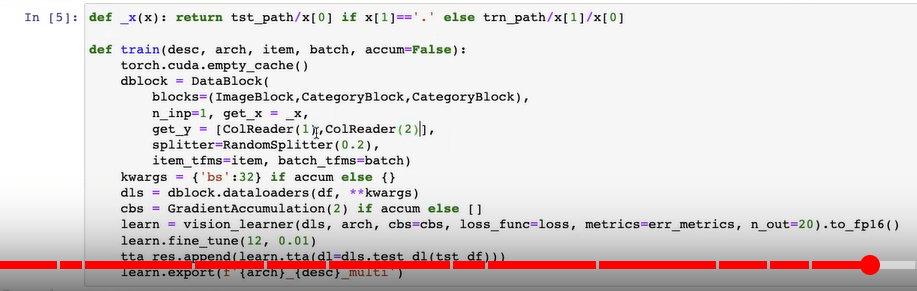
- min 38 transformblock and Imageblock; great debugging from 41min. Transformblocks dont do anything at all, only store things, JH tries to demo wat to do and what is called in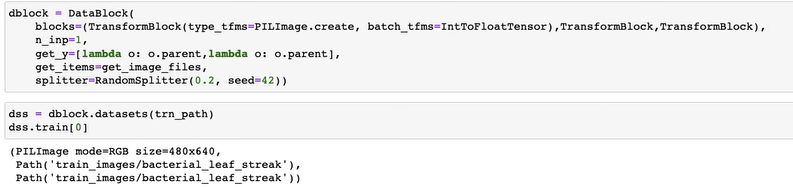
- 54min dataset vs dataloader. dataset you can index to and returns a single tuple of X, y. same as pytorch. Dataloader you cant index, you can iterate he gives you a batch, 
- 56min from what i can tell get_x and get_y functionality can also be passed to TransformBlock type_tfms. JH what goes into `type_tfms`  anything you want to look and index that thing. Rule is type trfms need to transform into a tensor. It's a convineant thing to look at.  below is the same as above 
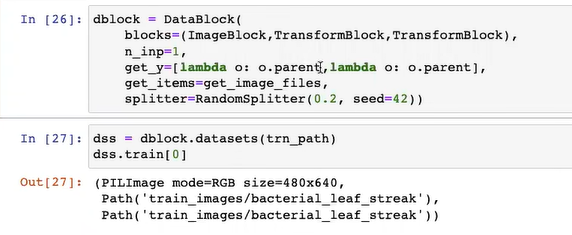
- CategoryBlock 1h and the introduction to vocabs
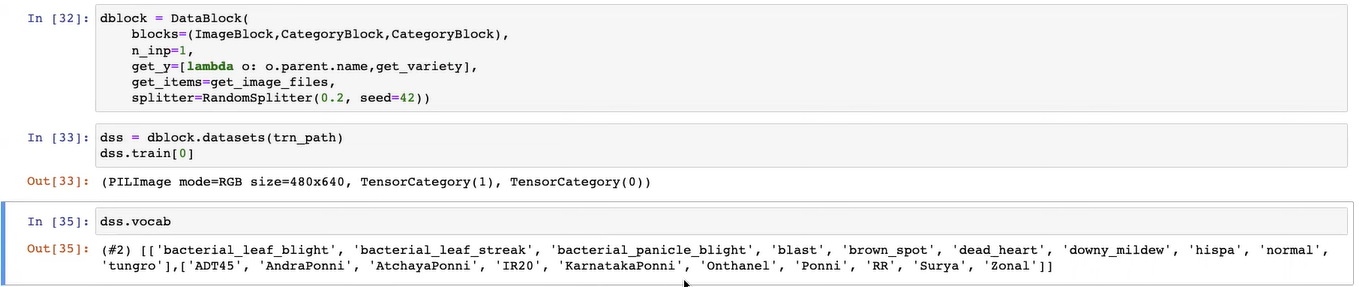
- so the navigation for items is as such (RaDEK ? at 1:001. get_items kwarg gets us the rows and the examples, from get_itms we use get_y or get_x to transform it somehow so then we can pass them into the type transforms of each block. think of type_transforms in the blocks as bulding on what is also done by get_x or get_y. For example `ImageBlock`. get_x will get you the image path to pass to type_tfmd in ImageBlock. if you look into src for ImageBlock it instantiates PiLImage and transform the pixels in image to float. 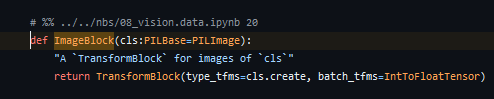
- Blocks are very usual tfms
- one nonte to keep is the item_tfms, how does it know where the items_tfms need to be applied, some ` typedespatch` is handle by fastai, siamese twins example is a good one to understand.  as it has two images to content in get_y, ie, two imageblock in y
- now you can create dataloade from our datablock, pass it to a siumple model and view a batch
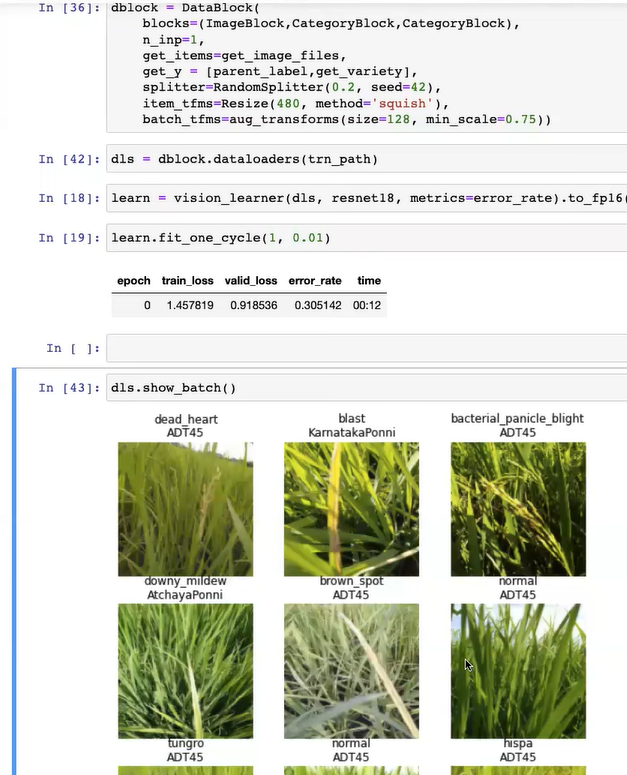


In [1]:
# !pip install -Uq --user nbdev
# !pip install huggingface_hub -U
!pip install -Uq --user 'timm==0.6.2.dev0'
!pip install fastai 'fastai>2.7.10'
try: import timm
except ModuleNotFoundError:
    !pip install -Uq 'timm==0.6.2.dev0'
try: import kaggle
except ModuleNotFoundError:
    !pip install -Uq --user 'kaggle'
from fastai.vision.all import *

In [2]:
timm.__version__

'0.6.2.dev0'

In [3]:
# paperspace runs diff version sof fastai for diff GPUs
# its really annoying
import fastai
fastai.__version__

'2.7.14'

In [4]:
# easier to read
Path.BASE_PATh = path = Path('/notebooks/paddy/data')
train_images = path / 'train_images'
test_images = path / 'test_images'
test_images_files = get_image_files(test_images).sorted()
    

In [5]:
path.ls()

(#5) [Path('/notebooks/paddy/data/sample_submission.csv'),Path('/notebooks/paddy/data/test_images'),Path('/notebooks/paddy/data/train_images'),Path('/notebooks/paddy/data/train.csv'),Path('/notebooks/paddy/data/paddy-disease-classification.zip')]

In [6]:
try: df = pd.read_csv(path/'train.csv')
except FileNotFoundError:
    !paddy/get_data.sh
    df = pd.read_csv(path/'train.csv')

In [7]:
# looking at variety
df['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [8]:
# in paddy small we used image dataloader from folder, here we replicate but using DataBlock api
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    get_y=parent_label, 
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=.75)
)

In [9]:
fn = get_image_files(train_images)[0]

In [10]:
parent_label(fn)

'bacterial_panicle_blight'

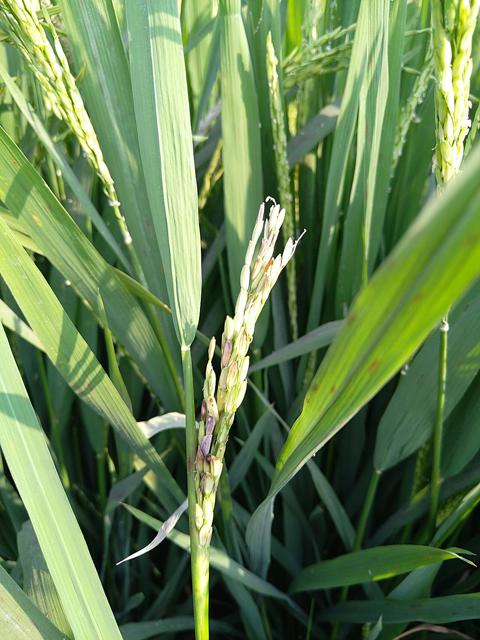

In [11]:
PILImage.create(fn)

In [12]:
dls = dblock.dataloaders(train_images)

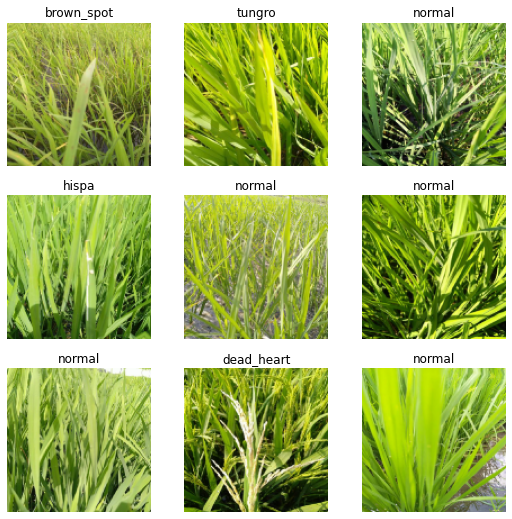

In [13]:
dls.show_batch()

In [14]:
# test with a small set up
learn = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.fit_one_cycle(1,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.499687,0.922234,0.296492,00:25


## Dive into DataBlock - anki

- Transform Block the simplest block in fast ai, it actually does not do anything but the number of transform blocks created will devise a number of pipelines. These dont do anything but store the list of things that will get called later on. 
- Imageblock and Category block use TransformBlock under the hood and also carry out some transforms for their own
- The first thing the datablock calls is get_x and get_y, than the result of tht is passes to TransformBlock. Several transforms will be called (type, items and batch) some at dataset time (type) and others a dataloader type (item batch for example). Type transforms will create Datasets. Datasets need to create tensors, and is something you can index to and returns a tuple of a input , label (if applicable) pairs  
- Data Loaders is something you can iterate (cant index to) this so item and batch transforms can be done at data loaders time. 
- So to summarise the data from from get items (or df) to get_x,y then to the TransformBlocks. type transforms are called in after, then at dataloader type items and batch transforms. Look into below to see more on the order. 
- A dataset returns a tuple (X, y) you can index to, a dataloader allows you to iterates over a dataset in bacthes. (pytorch fast ai defenitions)


In [15]:
TransformBlock??

Init signature:
TransformBlock(
    type_tfms: 'list' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    dl_type: 'TfmdDL' = None,
    dls_kwargs: 'dict' = None,
)
Source:        
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, 
        type_tfms:list=None, # One or more `Transform`s
        item_tfms:list=None, # `ItemTransform`s, applied on an item
        batch_tfms:list=None, # `Transform`s or `RandTransform`s, applied by batch
        dl_type:TfmdDL=None, # Task specific `TfmdDL`, defaults to `TfmdDL`
        dls_kwargs:dict=None, # Additional arguments to be passed to `DataLoaders`
    ):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
File:           ~/.local/lib/python3.9/site-packages/fastai/

In [16]:
# DataBlock??

In [17]:
dblock_simple = DataBlock(
    blocks=(TransformBlock,TransformBlock),
    get_items=get_image_files, # reads from a source, this case a path
    splitter=RandomSplitter(0.2, seed=42),
)

In [18]:
dss_simple = dblock_simple.datasets(train_images)

In [19]:
# simply passes the x from get_items
# is not really doing much
dss_simple[0]

(Path('/notebooks/paddy/data/train_images/bacterial_panicle_blight/109162.jpg'),
 Path('/notebooks/paddy/data/train_images/bacterial_panicle_blight/109162.jpg'))

In [20]:
dblock_simple = DataBlock(
    blocks=(TransformBlock,TransformBlock, TransformBlock),
    get_x=[lambda p: p.name, lambda p: p.name + '-- a stub test'],
    get_y=lambda p: p.parent,
    get_items=get_image_files, # reads from a source, this case a path
    splitter=RandomSplitter(0.2, seed=42),
)

In [21]:
dss_simple = dblock_simple.datasets(train_images)

In [22]:
print(fn)
fn.parent.name

/notebooks/paddy/data/train_images/bacterial_panicle_blight/109162.jpg


'bacterial_panicle_blight'

### Using ImageBlock and Category Block

In [24]:
# lets map file name to variety
img2variety = { row.image_id:row.variety
               for row in df.itertuples()}

def getvariety(p):return img2variety[p.name] # will receive get_image_files output


In [25]:
dblock_simple = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_y=[lambda p: p.parent.name, getvariety],
    get_items=get_image_files, # reads from a source, this case a path
    splitter=RandomSplitter(0.2, seed=42),
)

In [26]:
# what is get_items passing to TransformBlock
# just a simple type of TransformBlock
ImageBlock??

Signature: ImageBlock(cls: 'PILBase' = <class 'fastai.vision.core.PILImage'>)
Source:   
def ImageBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
File:      ~/.local/lib/python3.9/site-packages/fastai/vision/data.py
Type:      function


In [27]:
CategoryBlock??

Signature:
CategoryBlock(
    vocab: 'MutableSequence | pd.Series' = None,
    sort: 'bool' = True,
    add_na: 'bool' = False,
)
Source:   
def CategoryBlock(
    vocab:MutableSequence|pd.Series=None, # List of unique class names
    sort:bool=True, # Sort the classes alphabetically
    add_na:bool=False, # Add `#na#` to `vocab`
):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))
File:      ~/.local/lib/python3.9/site-packages/fastai/data/block.py
Type:      function


In [28]:
dss_simple = dblock_simple.datasets(train_images)

In [31]:
# simply passes the x from get_items
# Image block and Tensor outcputs for category labels
dss_simple.train[0]

(PILImage mode=RGB size=480x640, TensorCategory(8), TensorCategory(6))

In [32]:
dss_simple.vocab

(#2) [['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'],['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal']]

## Attempt to create a multi label DataBlock

In [34]:
# lets map file name to variety
img2variety = { row.image_id:row.variety
               for row in df.itertuples()}

def getvariety(p):return img2variety[p.name] # will receive get_image_files output


In [35]:
# start to create an DataBlock for the multicategory problem
# add an extra category block
# tell the data block what fns to use to get varaity
# tell the datablock how to retreive the variety via a function
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1, # required as to determine whats x,y
    get_items=get_image_files, # reads from a source, this case a path
    get_y=[parent_label, getvariety], 
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=.75)
)

In [36]:
fn

Path('/notebooks/paddy/data/train_images/bacterial_panicle_blight/109162.jpg')

In [37]:
dss = dblock.datasets(train_images) # datasets good for debug

In [38]:
# lets look into our first block output
dss.train[0] # also has a .valid

(PILImage mode=RGB size=480x640, TensorCategory(8), TensorCategory(6))

In [39]:
# debugging
# ImageBlock 
# PILImage.create(fn)

In [40]:
# catblock1
parent_label(fn)

'bacterial_panicle_blight'

In [41]:
# catblock2
getvariety(fn)

'ADT45'

In [42]:
dls = dblock.dataloaders(train_images)
dls

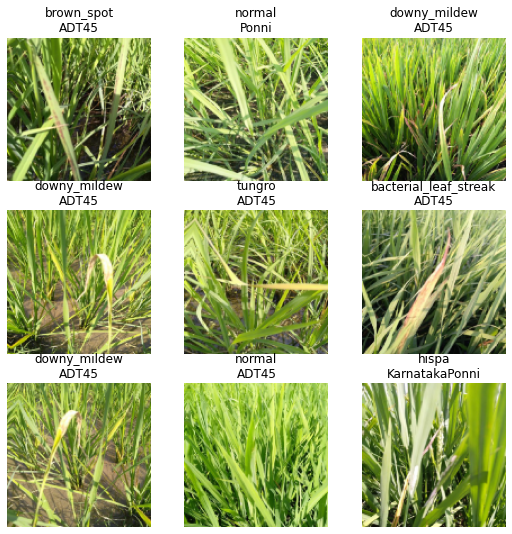

In [43]:
dls.show_batch()

### Handle loss for multilabels


In [59]:
orig_lf = CrossEntropyLossFlat()

def disease_err(inp, disease, variety): return error_rate(inp[:, :10], disease)
def variety_err(inp, disease, variety): return error_rate(inp[:, 10:], variety)
def disease_loss(inp, disease, variety): return orig_lf(inp[:, :10], disease)
def variety_loss(inp, disease, variety): return orig_lf(inp[:, 10:], variety)
def loss(pred, disease, variety): return orig_lf(pred[:, :10], disease) + orig_lf(pred[:, 10:], variety)

err_metrics = (disease_err, variety_err)
all_metrics = err_metrics + (disease_loss, variety_loss)

In [61]:
# now fit a leaner to see if it works 
# need to tell the lernear 20 putputs will be required

learn = vision_learner(dls, resnet18, loss_func=loss,
                       metrics=all_metrics, n_out=20).to_fp16()
learn.fine_tune(12, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,5.264545,3.576052,0.788083,0.326766,2.243638,1.332415,00:21


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,4.239958,3.414150,0.765497,0.324844,2.169415,1.244735,00:22
1,3.931493,3.192130,0.720327,0.317636,2.041548,1.150581,00:22
2,3.510473,2.960958,0.653051,0.302259,1.915247,1.045711,00:21
3,3.231664,2.798314,0.612206,0.294089,1.817944,0.980370,00:21
4,3.025447,2.646546,0.573282,0.289284,1.717206,0.929340,00:22
5,2.888379,2.541732,0.547814,0.285920,1.651256,0.890475,00:22
6,2.752228,2.421763,0.520423,0.285440,1.562523,0.859240,00:22
7,2.695801,2.334463,0.507929,0.280154,1.507407,0.827056,00:22
8,2.631754,2.298949,0.500721,0.274387,1.480926,0.818023,00:22
9,2.586746,2.273310,0.493032,0.270543,1.464260,0.809049,00:22


### Datablock using a df
small diversion using a df as the source to a datablock. Its very versatile

In [54]:
df.head(1)

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45


In [55]:
# x is a dataframe row
def _x(x): return test_images/x[0] if x[1] == "." else train_images/x[1]/x[0] # hacky handle train/inference paths
def _y_dis(x): return x.label
def _y_var(x): return x.variety

dblock_df = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_x= _x, 
    # get_y=[_y_dis, _y_var],
    get_y=[ColReader(1), ColReader(2)], # handy fastai way to read cols, check tutorials for eg 
    splitter=RandomSplitter(.2),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=.75)
)
    

In [56]:
dls_df = dblock_df.dataloaders(df)

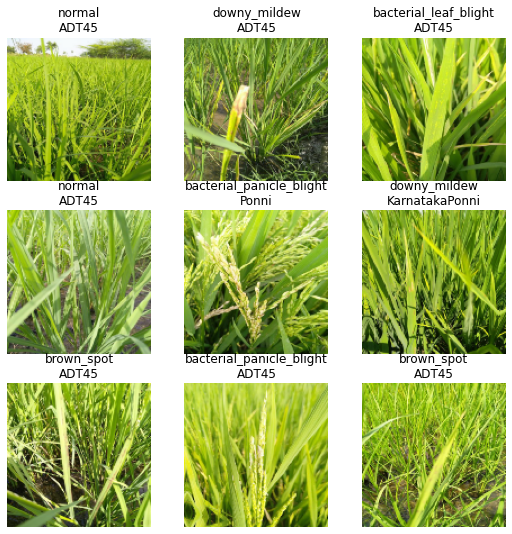

In [57]:
dls_df.show_batch()

In [62]:
# now fit a leaner to see if it works

learn = vision_learner(dls_df, resnet18, loss_func=loss,
                       metrics=all_metrics, n_out=20).to_fp16()
learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.968460,2.765605,0.600673,0.272946,1.795656,0.969949,00:32


## WT 14 Notes

From 26 min. Progressive resizing skipped. looks into training the model in increaseling bigger image sizes and not have this static accross all epochs. also some mention in WT14. 